In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format = 'svg'
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from folium.plugins import FloatImage
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from shapely.geometry import Point


     osm_id  code  fclass   name  \
0  31352156  7202    park   儿童公园   
1  31355768  7202    park   人民公园   
2  41281446  7202    park  莲花山公园   
3  51191254  7201  forest   None   
4  51191255  7201  forest   None   

                                            geometry  
0  MULTIPOLYGON (((114.11802 22.55546, 114.11812 ...  
1  MULTIPOLYGON (((114.10992 22.5547, 114.11001 2...  
2  MULTIPOLYGON (((114.04419 22.55648, 114.04426 ...  
3  MULTIPOLYGON (((114.14957 22.58459, 114.14964 ...  
4  MULTIPOLYGON (((114.15101 22.58626, 114.15107 ...  


C:\Users\MOMO\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MOMO\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22323 (\N{CJK UNIFIED IDEOGRAPH-5733}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MOMO\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MOMO\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MOMO\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170:

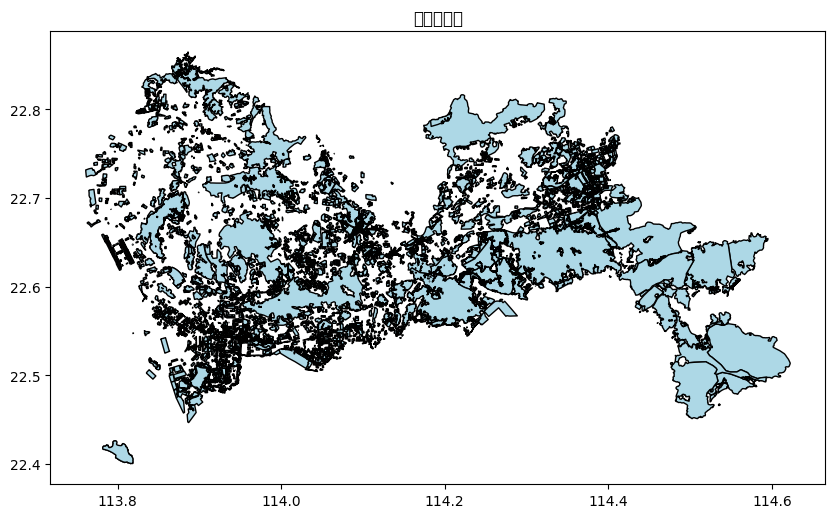

In [3]:
# 文件路径，确保路径和文件名正确
file_path = r"E:\数据挖掘与商务分析\Final\Shared-Bike-Mining\Datas\深圳市POI数据.geojson"

try:
    # 使用 GeoPandas 读取 GeoJSON 文件
    shenzhen_map = gpd.read_file(file_path)
    
    # 显示 GeoDataFrame 的前几行，验证数据读取是否成功
    print(shenzhen_map.head())
    
    # 可视化深圳市边界
    shenzhen_map.plot(edgecolor="black", color="lightblue", figsize=(10, 8))
    plt.title("深圳市边界")
    plt.show()

except FileNotFoundError:
    print("文件未找到，请检查路径是否正确：", file_path)
except Exception as e:
    print("读取文件时发生错误：", e)

In [4]:
#读取E:\数据挖掘与商务分析\Final\Analyze\DATA_Cleaned.csv文件
bike_data = pd.read_csv(r"E:\数据挖掘与商务分析\Final\Analyze\DATA_Cleaned.csv")

# 查看数据的前几行
print(bike_data.head())

# 查看数据的基本信息
print(bike_data.info())

            START_TIME  START_LAT             END_TIME     END_LNG  \
0  2021-07-18 23:37:10  22.722193  2021-07-19 00:30:48  114.293735   
1  2021-07-18 23:37:11  22.630734  2021-07-18 23:45:18  114.051401   
2  2021-07-18 23:37:11  22.630641  2021-07-18 23:45:18  114.051307   
3  2021-07-18 23:37:11  22.587205  2021-07-18 23:48:36  113.873857   
4  2021-07-18 23:37:11  22.583960  2021-07-18 23:52:19  113.956495   

    START_LNG    END_LAT                       start_point  \
0  114.287819  22.716855      POINT (114.287819 22.722193)   
1  114.055318  22.635949  POINT (114.05531813 22.63073398)   
2  114.055225  22.635856  POINT (114.05522493 22.63064078)   
3  113.861478  22.580957    POINT (113.8614776 22.5872051)   
4  113.954422  22.580334       POINT (113.954422 22.58396)   

                              end_point   distance_m  duration_min  speed_m_s  
0          POINT (114.293735 22.716855)   847.831888     53.633333   0.263465  
1      POINT (114.05140056 22.63594924)   704.

In [5]:
# 将自行车数据转换为 GeoDataFrame，生成起点和终点几何列
bike_data['start_point'] = bike_data.apply(lambda row: Point(row['START_LNG'], row['START_LAT']), axis=1)
bike_data['end_point'] = bike_data.apply(lambda row: Point(row['END_LNG'], row['END_LAT']), axis=1)

bike_start_gdf = gpd.GeoDataFrame(bike_data, geometry='start_point', crs="EPSG:4326")
bike_end_gdf = gpd.GeoDataFrame(bike_data, geometry='end_point', crs="EPSG:4326")

In [6]:
# 确保深圳地图的 CRS 与自行车数据一致
shenzhen_map = shenzhen_map.to_crs(bike_start_gdf.crs)

# 分别进行空间连接，找到起点和终点所在的区域
bike_start_with_region = gpd.sjoin(bike_start_gdf, shenzhen_map, how="left", predicate="intersects")
bike_end_with_region = gpd.sjoin(bike_end_gdf, shenzhen_map, how="left", predicate="intersects")


In [7]:
# 提取区域名称并重命名列
bike_start_with_region = bike_start_with_region[['START_TIME', 'START_LAT', 'START_LNG', 'name']].rename(columns={'name': 'start_region'})
bike_end_with_region = bike_end_with_region[['END_TIME', 'END_LAT', 'END_LNG', 'name']].rename(columns={'name': 'end_region'})


In [8]:
# 合并起点和终点的区域划分信息
bike_with_regions = pd.merge(bike_start_with_region, bike_end_with_region, left_index=True, right_index=True, how="inner")

# 查看结果
print(bike_with_regions.head())

            START_TIME  START_LAT   START_LNG start_region  \
0  2021-07-18 23:37:10  22.722193  114.287819          NaN   
1  2021-07-18 23:37:11  22.630734  114.055318          NaN   
2  2021-07-18 23:37:11  22.630641  114.055225          NaN   
3  2021-07-18 23:37:11  22.587205  113.861478          NaN   
4  2021-07-18 23:37:11  22.583960  113.954422      大沙河生态长廊   

              END_TIME    END_LAT     END_LNG end_region  
0  2021-07-19 00:30:48  22.716855  114.293735        NaN  
1  2021-07-18 23:45:18  22.635949  114.051401        NaN  
2  2021-07-18 23:45:18  22.635856  114.051307        NaN  
3  2021-07-18 23:48:36  22.580957  113.873857        NaN  
4  2021-07-18 23:52:19  22.580334  113.956495       None  


In [9]:
# 保存结果到 CSV 文件
output_path = "bike_with_regions.csv"
bike_with_regions.to_csv(output_path, index=False, encoding='utf-8-sig')  # 确保保存为 UTF-8 格式

print(f"结果已保存到 {output_path}")

结果已保存到 bike_with_regions.csv


地理栈格化

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format = 'svg'
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from folium.plugins import FloatImage
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from shapely.geometry import Point


In [13]:
# 读取GeoJSON文件
file_path = r'E:\数据挖掘与商务分析\Final\深圳市边界_440300_GeoJSON_(poi86.com)\440300.geojson'
gdf = gpd.read_file(file_path)


In [14]:
# 获取边界的最南、最北、最西、最东经纬度
bounds = gdf.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds

# 打印边界信息
print(f"最南纬度: {min_lat}")
print(f"最北纬度: {max_lat}")
print(f"最西经度: {min_lon}")
print(f"最东经度: {max_lon}")


最南纬度: 22.399287
最北纬度: 22.864719
最西经度: 113.74628
最东经度: 114.62397


In [55]:
# 小格的边长（单位：米）
grid_size = 500  

# 存储每个小格的四个角的经纬度
grid_corners = []

# 当前起始点设置为矩形区域的左上角
current_lat = max_lat
current_lon = min_lon

while current_lat > min_lat:  # 从上往下划分
    current_lon = min_lon  # 每行从左往右划分
    while current_lon < max_lon:
        
        # 记录当前小格的左上角经纬度
        top_left = (current_lat, current_lon)
        
        # 计算右上角
        top_right_point = geodesic(meters=grid_size).destination(top_left, 90)  # 方向90°（正东）
        top_right = (top_right_point.latitude, top_right_point.longitude)
        
        # 计算右下角
        bottom_right_point = geodesic(meters=grid_size).destination(top_right, 180)  # 方向180°（正南）
        bottom_right = (bottom_right_point.latitude, bottom_right_point.longitude)
        
        # 计算左下角
        bottom_left_point = geodesic(meters=grid_size).destination(top_left, 180)  # 方向180°（正南）
        bottom_left = (bottom_left_point.latitude, bottom_left_point.longitude)
        
        # 存储四个角的经纬度
        grid_corners.append((top_left, top_right, bottom_right, bottom_left))

        # 向右移动一个小格
        next_point = geodesic(meters=grid_size).destination((current_lat, current_lon), 90)  # 方向90°（正东）
        current_lon = next_point.longitude
    # 向下移动一个小格
    next_point = geodesic(meters=grid_size).destination((current_lat, current_lon), 180)  # 方向180°（正南）
    current_lat = next_point.latitude


In [56]:
# 打印一些结果
print(f"总共生成了 {len(grid_corners)} 个小格")
print(f"示例左上角经纬度: {grid_corners[:5]}")  # 显示前5个小格的经纬度

总共生成了 18824 个小格
示例左上角经纬度: [((np.float64(22.864719), np.float64(113.74628)), (22.864718925410422, 113.75115213480818), (22.86020393030795, 113.75115213480818), (22.86020400489757, 113.74628)), ((np.float64(22.864719), 113.75115213480818), (22.864718925410422, 113.75602426961636), (22.86020393030795, 113.75602426961636), (22.86020400489757, 113.75115213480818)), ((np.float64(22.864719), 113.75602426961636), (22.864718925410422, 113.76089640442454), (22.86020393030795, 113.76089640442454), (22.86020400489757, 113.75602426961636)), ((np.float64(22.864719), 113.76089640442454), (22.864718925410422, 113.76576853923272), (22.86020393030795, 113.76576853923272), (22.86020400489757, 113.76089640442454)), ((np.float64(22.864719), 113.76576853923272), (22.864718925410422, 113.7706406740409), (22.86020393030795, 113.7706406740409), (22.86020400489757, 113.76576853923272))]


In [7]:
# 定义文件路径
file_path = r'E:\数据挖掘与商务分析\Final\Analyze\DATA_Cleaned.csv'

# 读取CSV文件
try:
    data = pd.read_csv(file_path)
    # 显示数据的前几行
    data_preview = data.head()
    data_info = data.info()
except Exception as e:
    data_preview = None
    data_info = str(e)

data_preview, data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9462675 entries, 0 to 9462674
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   START_TIME    object 
 1   START_LAT     float64
 2   END_TIME      object 
 3   END_LNG       float64
 4   START_LNG     float64
 5   END_LAT       float64
 6   start_point   object 
 7   end_point     object 
 8   distance_m    float64
 9   duration_min  float64
 10  speed_m_s     float64
dtypes: float64(7), object(4)
memory usage: 794.1+ MB


(            START_TIME  START_LAT             END_TIME     END_LNG  \
 0  2021-07-18 23:37:10  22.722193  2021-07-19 00:30:48  114.293735   
 1  2021-07-18 23:37:11  22.630734  2021-07-18 23:45:18  114.051401   
 2  2021-07-18 23:37:11  22.630641  2021-07-18 23:45:18  114.051307   
 3  2021-07-18 23:37:11  22.587205  2021-07-18 23:48:36  113.873857   
 4  2021-07-18 23:37:11  22.583960  2021-07-18 23:52:19  113.956495   
 
     START_LNG    END_LAT                       start_point  \
 0  114.287819  22.716855      POINT (114.287819 22.722193)   
 1  114.055318  22.635949  POINT (114.05531813 22.63073398)   
 2  114.055225  22.635856  POINT (114.05522493 22.63064078)   
 3  113.861478  22.580957    POINT (113.8614776 22.5872051)   
 4  113.954422  22.580334       POINT (113.954422 22.58396)   
 
                               end_point   distance_m  duration_min  speed_m_s  
 0          POINT (114.293735 22.716855)   847.831888     53.633333   0.263465  
 1      POINT (114.05140056 22

df index day 1num 1-3 4-5 

In [8]:
# 数据存储在名为 data 的 DataFrame 中
data['START_TIME'] = pd.to_datetime(data['START_TIME'])  # 确保 START_TIME 是 datetime 类型

# 计算时间段编号
data['start_time_slot'] = data['START_TIME'].dt.hour * 2 + (data['START_TIME'].dt.minute // 30)

# 检查结果
print(data[['START_TIME', 'start_time_slot']])

                 START_TIME  start_time_slot
0       2021-07-18 23:37:10               47
1       2021-07-18 23:37:11               47
2       2021-07-18 23:37:11               47
3       2021-07-18 23:37:11               47
4       2021-07-18 23:37:11               47
...                     ...              ...
9462670 2021-07-11 22:50:33               45
9462671 2021-07-11 22:51:00               45
9462672 2021-07-11 22:51:02               45
9462673 2021-07-11 22:51:03               45
9462674 2021-07-11 22:51:08               45

[9462675 rows x 2 columns]


In [65]:
data.head()


,START_TIME,START_LAT,END_TIME,END_LNG,START_LNG,END_LAT,start_point,end_point,distance_m,duration_min,speed_m_s,start_time_slot
0,2021-07-18 23:37:10,22.722193,2021-07-19 00:30:48,114.293735,114.287819,22.716855,POINT (114.287819 22.722193),POINT (114.293735 22.716855),847.831888,53.633333,0.263465,47
1,2021-07-18 23:37:11,22.630734,2021-07-18 23:45:18,114.051401,114.055318,22.635949,POINT (114.05531813 22.63073398),POINT (114.05140056 22.63594924),704.076357,8.116667,1.445742,47
2,2021-07-18 23:37:11,22.630641,2021-07-18 23:45:18,114.051307,114.055225,22.635856,POINT (114.05522493 22.63064078),POINT (114.05130736 22.63585604),704.076507,8.116667,1.445742,47
3,2021-07-18 23:37:11,22.587205,2021-07-18 23:48:36,113.873857,113.861478,22.580957,POINT (113.8614776 22.5872051),POINT (113.8738566035 22.5809568497),1448.874169,11.416667,2.115145,47
4,2021-07-18 23:37:11,22.583960,2021-07-18 23:52:19,113.956495,113.954422,22.580334,POINT (113.954422 22.58396),POINT (113.956495 22.580334),454.616893,15.133333,0.500679,47


In [73]:
#将data储存为bike_start_time_slot.csv
data.to_csv('bike_start_time_slot.csv', index=False)

In [57]:
# 初始化一个空的列表，用来存储每个格子的时间段数据
grid_start_time_slot = []

# 遍历每个格子的四个角
for corners in grid_corners:
    # 格子位置数据：四个角的经纬度
    grid_position = corners
    # 初始化时间段列，列从第2列到第49列，初始值为0
    time_slots = [0] * 48  # 创建一个长度为48的列表，表示48个时间段，初始化为0
    # 将格子位置和时间段数据合并
    grid_data = [grid_position] + time_slots
    # 将数据添加到grid_start_time_slot列表中
    grid_start_time_slot.append(grid_data)

In [61]:
# 将grid_start_time_slot转换为DataFrame，便于查看和操作
columns = ['Grid_Position'] + [f"Time_Slot_{i+1}" for i in range(48)]  # 列名：第一列是格子位置，后面48列是时间段
df = pd.DataFrame(grid_start_time_slot, columns=columns)

# 打印DataFrame
print(df)

                                           Grid_Position  Time_Slot_1  \
0      ((22.864719, 113.74628), (22.864718925410422, ...            0   
1      ((22.864719, 113.75115213480818), (22.86471892...            0   
2      ((22.864719, 113.75602426961636), (22.86471892...            0   
3      ((22.864719, 113.76089640442454), (22.86471892...            0   
4      ((22.864719, 113.76576853923272), (22.86471892...            0   
...                                                  ...          ...   
18819  ((22.39966112413248, 114.6008953169284), (22.3...            0   
18820  ((22.39966112413248, 114.60575108577459), (22....            0   
18821  ((22.39966112413248, 114.61060685462077), (22....            0   
18822  ((22.39966112413248, 114.61546262346695), (22....            0   
18823  ((22.39966112413248, 114.62031839231314), (22....            0   

       Time_Slot_2  Time_Slot_3  Time_Slot_4  Time_Slot_5  Time_Slot_6  \
0                0            0            0     

In [ ]:
# 将 'START_TIME' 列转换为 datetime 类型
data['START_TIME'] = pd.to_datetime(data['START_TIME'])

# 提取 'START_TIME' 列的日期部分，并与 '2021-07-19' 进行比较
newdata = data[data['START_TIME'].dt.date == pd.to_datetime('2021-07-17').date()]

# 查看 newdata 的最后 5 行
print(newdata.tail())

#查看列名
newdata.columns


                 START_TIME  START_LAT             END_TIME     END_LNG  \
2639136 2021-07-17 00:10:36  22.664649  2021-07-17 00:21:21  113.811020   
2639137 2021-07-17 00:10:37  22.757887  2021-07-17 00:17:25  113.858896   
2639138 2021-07-17 00:10:37  22.724985  2021-07-17 00:17:15  114.259018   
2639139 2021-07-17 00:10:37  22.633604  2021-07-17 00:24:14  114.022588   
2639140 2021-07-17 00:10:37  22.560317  2021-07-17 00:22:34  113.870237   

          START_LNG    END_LAT                       start_point  \
2639136  113.805261  22.663329  POINT (113.80526134 22.66464936)   
2639137  113.837770  22.773116    POINT (113.8377702 22.7578866)   
2639138  114.254623  22.733614      POINT (114.254623 22.724985)   
2639139  114.025450  22.649137  POINT (114.02545014 22.63360414)   
2639140  113.884885  22.569573  POINT (113.88488544 22.56031698)   

                                    end_point   distance_m  duration_min  \
2639136      POINT (113.81101954 22.66332901)   609.591386     1

Index(['START_TIME', 'START_LAT', 'END_TIME', 'END_LNG', 'START_LNG',
       'END_LAT', 'start_point', 'end_point', 'distance_m', 'duration_min',
       'speed_m_s', 'start_time_slot'],
      dtype='object')

In [72]:
#查看newdata行数
newdata.shape

(1363915, 12)

In [67]:
# 函数：根据出发点的经纬度，找到最匹配的格子
def find_grid_by_coordinates(start_lat, start_lon, grid_corners):
    for i, corners in enumerate(grid_corners):
        top_left, top_right, bottom_right, bottom_left = corners
        # 判断出发点是否在当前格子内（矩形包含判断）
        if (min(top_left[0], bottom_left[0]) <= start_lat <= max(top_left[0], bottom_left[0])) and \
           (min(top_left[1], top_right[1]) <= start_lon <= max(top_left[1], top_right[1])):
            return i  # 返回匹配到的格子的索引
    return None  # 如果没有匹配的格子，返回None

# 遍历自行车订单数据
for _, row in newdata.iterrows():
    start_lat = row['START_LAT']
    start_lon = row['START_LNG']
    start_time = row['START_TIME']
    
    # 找到对应的格子
    grid_index = find_grid_by_coordinates(start_lat, start_lon, grid_corners)
    
    if grid_index is not None:
        # 根据订单的开始时间获取时间段列（假设 start_time_slot 是 0 到 47 的整数）
        time_slot_index = int(row['start_time_slot']) + 1  # 映射到 Time_Slot_1 到 Time_Slot_48（加1）
        
        # 在 grid_start_time_slot 对应的格子和时间段列增加 1
        df.at[grid_index, f'Time_Slot_{time_slot_index}'] += 1

# 打印结果
print(df)


                                           Grid_Position  Time_Slot_1  \
0      ((22.864719, 113.74628), (22.864718925410422, ...            0   
1      ((22.864719, 113.75115213480818), (22.86471892...            0   
2      ((22.864719, 113.75602426961636), (22.86471892...            0   
3      ((22.864719, 113.76089640442454), (22.86471892...            0   
4      ((22.864719, 113.76576853923272), (22.86471892...            0   
...                                                  ...          ...   
18819  ((22.39966112413248, 114.6008953169284), (22.3...            0   
18820  ((22.39966112413248, 114.60575108577459), (22....            0   
18821  ((22.39966112413248, 114.61060685462077), (22....            0   
18822  ((22.39966112413248, 114.61546262346695), (22....            0   
18823  ((22.39966112413248, 114.62031839231314), (22....            0   

       Time_Slot_2  Time_Slot_3  Time_Slot_4  Time_Slot_5  Time_Slot_6  \
0                0            0            0     

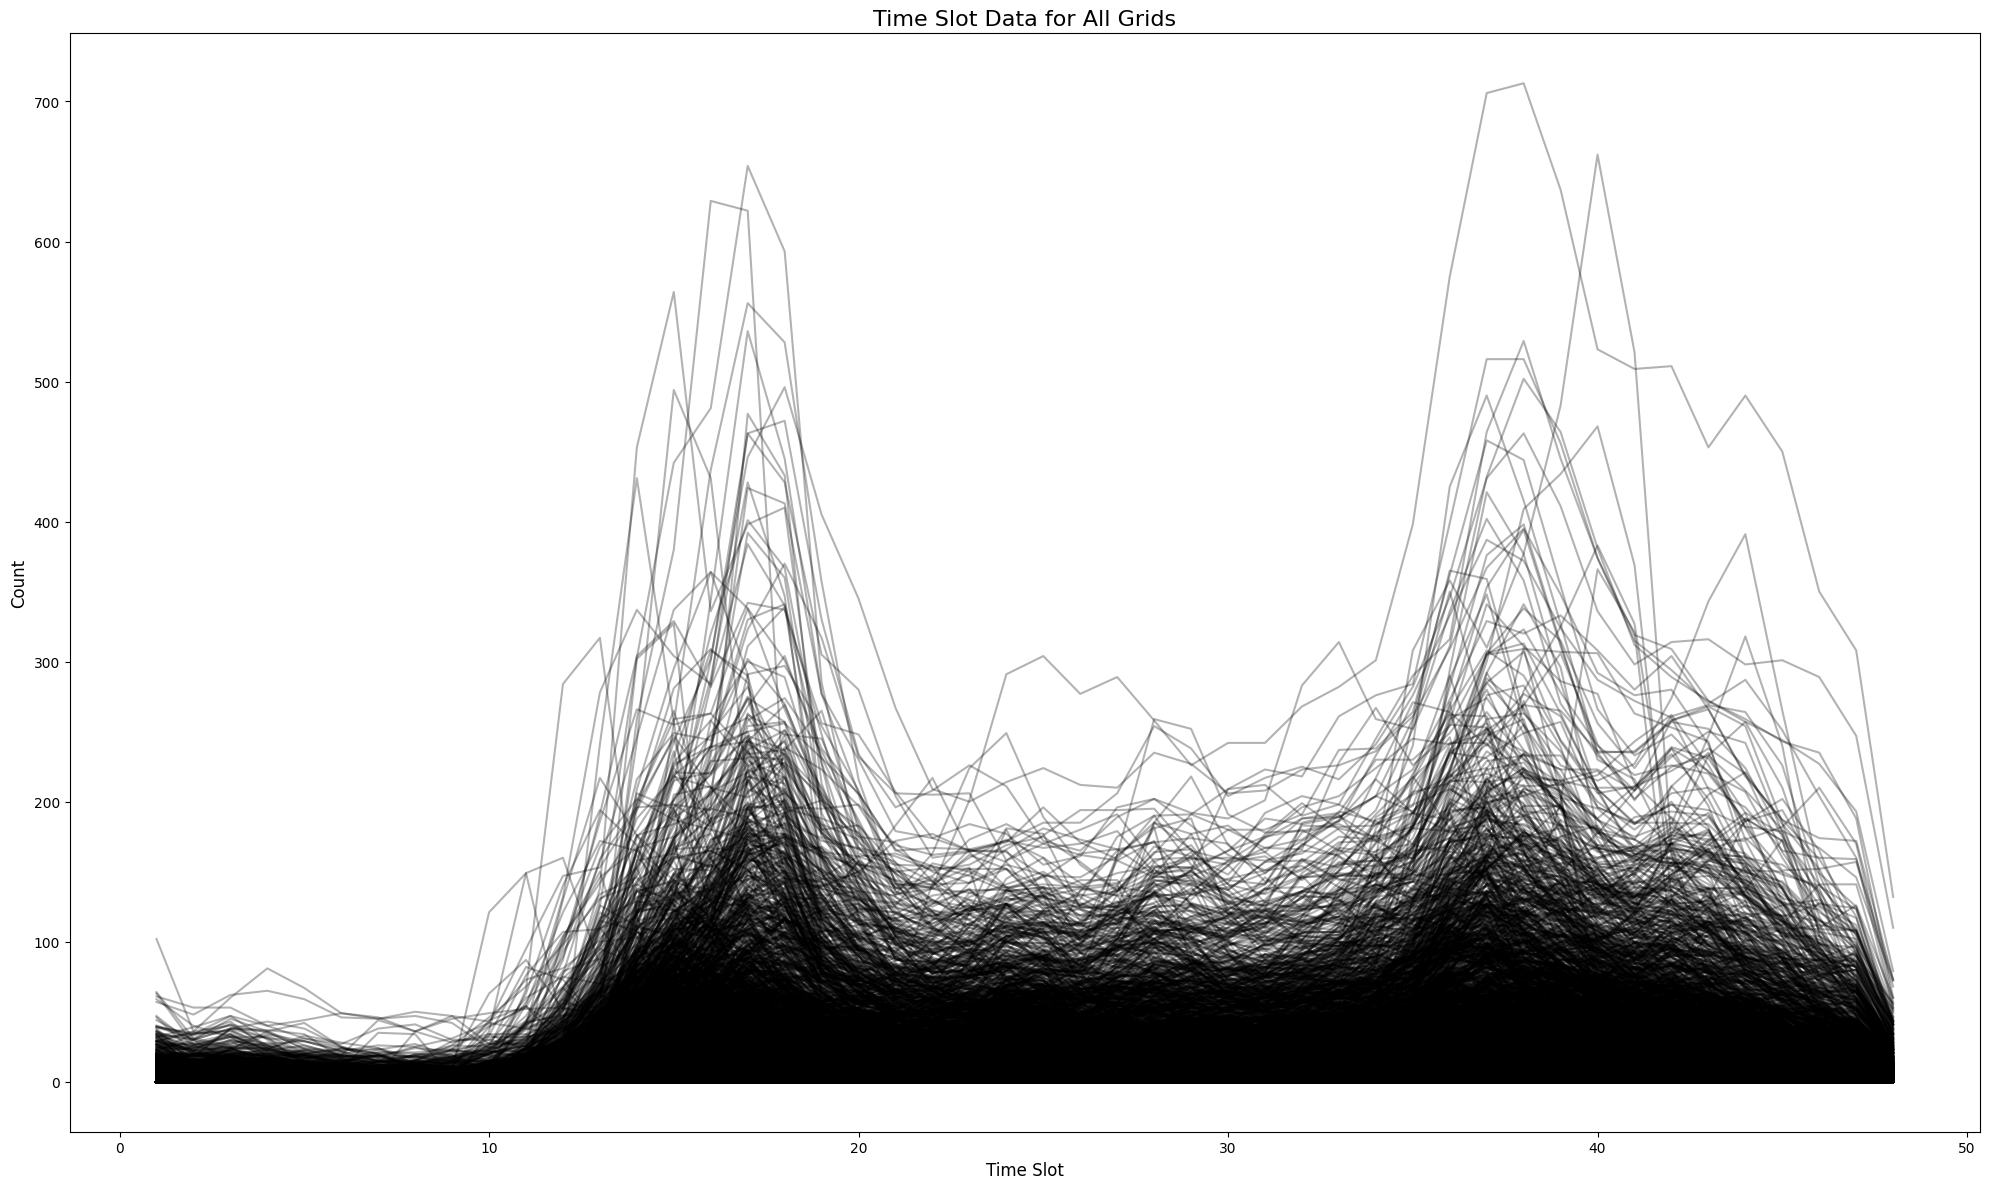

In [68]:
# 创建一个画布，设置图像尺寸
plt.figure(figsize=(20, 12))

# 遍历每个格子（每行）并绘制其时间段数据
for grid_index, row in df.iterrows():
    # 提取该格子的所有时间段数据
    time_slot_data = row[['Time_Slot_' + str(i) for i in range(1, 49)]]
    
    # 绘制该格子的时间段数据作为折线图
    plt.plot(range(1, 49), time_slot_data, color='black', alpha=0.3)  # 让每条线的透明度稍微低一些，以便更清晰

# 设置图像的标题和轴标签
plt.title("Time Slot Data for All Grids", fontsize=16)
plt.xlabel("Time Slot", fontsize=12)
plt.ylabel("Count", fontsize=12)

# 显示图表
plt.tight_layout()
plt.show()

In [69]:
#将df储存为Grids_Time_Slot.csv
df.to_csv('Grids_Time_Slot.csv', index=False)

In [4]:
#读取Grids_Time_Slot.csv
df = pd.read_csv('Grids_Time_Slot.csv')

In [70]:
#统计Time_Slot_1到Time_Slot_48不全为0的格子数量
df[df[['Time_Slot_' + str(i) for i in range(1, 49)]].sum(axis=1) != 0].shape[0]

4551

In [6]:
#统计Time_Slot_1到Time_Slot_48的总和
df[['Time_Slot_' + str(i) for i in range(1, 49)]].sum().sum()

np.int64(2716271)